In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [69]:
# See how many devices are around
torch.cuda.device_count()
# Set it to a particular device
torch.cuda.set_device(1)
# Check which device you are on
torch.cuda.current_device()

1

# MURA

In [2]:
import sys
sys.path.append("../../fastai/")

In [3]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from sklearn.metrics import confusion_matrix

In [4]:
PATH = "/home/sathiesh/Deep_Learning_Kaliy/my_projects/mura/data/"  #MMIV
#PATH = "/Users/Sathiesh/MachineLearning/Deep_Learning_Kaliy/my_projects/mura/data/" #Home

In [5]:
os.listdir(PATH)

['test_submission_example.csv',
 'models',
 'tmp',
 'MURA-v1.0',
 'valid.csv',
 'test',
 'cleaned_label.csv',
 'train.csv']

In [6]:
df_train = pd.read_csv(f'{PATH}train.csv')
df_valid = pd.read_csv(f'{PATH}valid.csv')

In [7]:
df_train.head()

,MURA-v1.0/train/XR_SHOULDER/patient00001/study1_positive/image1.png,1
0,MURA-v1.0/train/XR_SHOULDER/patient00001/study...,1
1,MURA-v1.0/train/XR_SHOULDER/patient00001/study...,1
2,MURA-v1.0/train/XR_SHOULDER/patient00002/study...,1
3,MURA-v1.0/train/XR_SHOULDER/patient00002/study...,1
4,MURA-v1.0/train/XR_SHOULDER/patient00002/study...,1


In [8]:
df_train.columns = ['Image Index', 'Abnormality']

In [9]:
df_valid.columns = ['Image Index', 'Abnormality']

In [10]:
df_train.shape, df_valid.shape

((37110, 2), (3224, 2))

In [11]:
df = pd.concat([df_train, df_valid], ignore_index=True)
df.head()

,Image Index,Abnormality
0,MURA-v1.0/train/XR_SHOULDER/patient00001/study...,1
1,MURA-v1.0/train/XR_SHOULDER/patient00001/study...,1
2,MURA-v1.0/train/XR_SHOULDER/patient00002/study...,1
3,MURA-v1.0/train/XR_SHOULDER/patient00002/study...,1
4,MURA-v1.0/train/XR_SHOULDER/patient00002/study...,1


In [12]:
df.shape

(40334, 2)

In [13]:
df['Abnormality'] = df['Abnormality'].astype('bool')

In [14]:
#val_idxs = np.array(range(len(df_train), len(df))) #denne hjelper vel ikke lenger

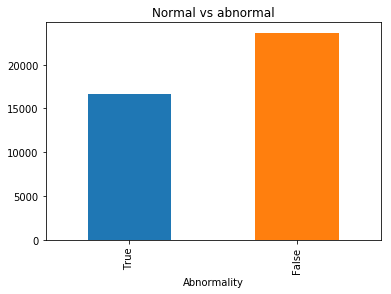

In [15]:
df_sorted = df.pivot_table(index='Abnormality', aggfunc=len).sort_values('Image Index') 
#df_sorted.index = [disease_name,'Other']
df_sorted['Image Index'].plot(kind='bar', title="Normal vs abnormal")

In [16]:
df_sorted

,Image Index
Abnormality,
True,16663
False,23671


In [17]:
normal_count = df_sorted['Image Index'][0]
abnormality_count = df_sorted['Image Index'][1]

df = df.append([df]*1, ignore_index=True) 

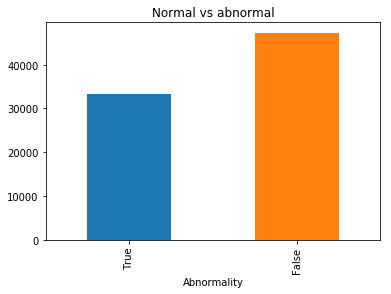

In [18]:
df_sorted = df.pivot_table(index='Abnormality', aggfunc=len).sort_values('Image Index') 
df_sorted['Image Index'].plot(kind='bar', title="Normal vs abnormal")

In [19]:
cleaned_label_path = f'{PATH}cleaned_label.csv'
df.to_csv(cleaned_label_path, index=False)

# View data

In [20]:
sz = 64
arch = dn121
bs = 16

In [21]:
def get_data(sz): 
    tfms = tfms_from_model(arch, sz, aug_tfms=RandomFlip())  #transforms_side_on
    return ImageClassifierData.from_csv(PATH ,'', cleaned_label_path , test_name='test', tfms=tfms, bs=bs);

In [22]:
data = get_data(sz)

In [23]:
fn = PATH+data.trn_ds.fnames[10]
fn 

'/home/sathiesh/Deep_Learning_Kaliy/my_projects/mura/data/MURA-v1.0/train/XR_ELBOW/patient00017/study1_positive/image3.png'

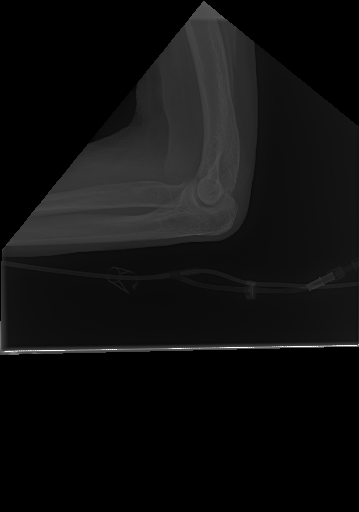

In [24]:
img = PIL.Image.open(fn);
img

In [25]:
data.trn_ds.fnames.shape ,data.val_ds.fnames.shape

((64535,), (16133,))

# Training

In [121]:
learn = ConvLearner.pretrained(arch, data, ps = 0.5, opt_fn=optim.Adam) 

 65%|██████▍   | 2619/4034 [02:10<01:10, 20.09it/s, loss=2.62] 

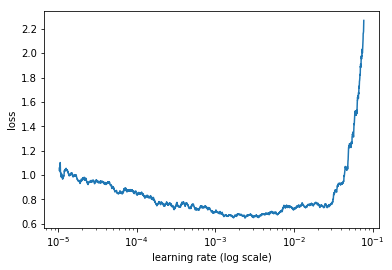

 65%|██████▍   | 2619/4034 [02:30<01:21, 17.46it/s, loss=2.62]

In [122]:
learn.lr_find()
learn.sched.plot()

In [123]:
lr = 0.0001

In [124]:
learn.fit(lr,3, cycle_len=1, cycle_mult =2) 

  1%|▏         | 53/4034 [00:02<03:44, 17.72it/s, loss=1.09]

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/sathiesh/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/sathiesh/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/sathiesh/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                      
    0      0.679917   0.579408   0.706564  
    1      0.613376   0.555884   0.720201                      
    2      0.59738    0.552395   0.724788                      
    3      0.593618   0.549271   0.728507                      
    4      0.553177   0.542188   0.734085                      
    5      0.568999   0.539604   0.735821                      
    6      0.576624   0.538706   0.736441                      



[array([0.53871]), 0.7364408355581482]

 65%|██████▌   | 1516/2320 [00:49<00:26, 30.90it/s, loss=2.44] 

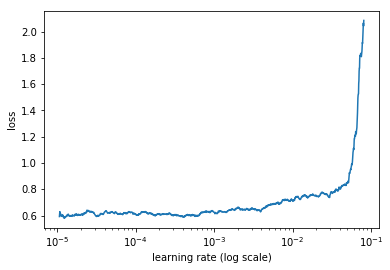

In [26]:
#learn.lr_find()
#learn.sched.plot()

In [125]:
lrs = [lr/9, lr/3, lr] #TODO uten TL bør jeg dele på 9 og 3
learn.unfreeze()

In [126]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                      
    0      0.57678    0.514648   0.752309  
    1      0.521952   0.472658   0.782929                      
    2      0.507793   0.458895   0.789314                      
    3      0.522544   0.445037   0.80326                       
    4      0.469708   0.4303     0.806856                      
    5      0.438662   0.402608   0.823653                      
    6      0.395666   0.399566   0.823839                      



[array([0.39957]), 0.8238393355234612]

In [127]:
learn.save(f'{sz}')

In [128]:
sz = 128

In [129]:
learn.set_data(get_data(sz))
learn.freeze()

In [130]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                      
    0      0.517342   0.482773   0.77859   
    1      0.498225   0.471663   0.78702                       
    2      0.493211   0.469986   0.787826                      
    3      0.487229   0.466392   0.789872                      
    4      0.504309   0.462229   0.791979                      
    5      0.478658   0.461225   0.793591                      
    6      0.473289   0.462605   0.791235                      



[array([0.46261]), 0.7912353561060934]

In [131]:
learn.unfreeze();
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                      
    0      0.449284   0.41842    0.821732  
    1      0.43695    0.401774   0.830596                      
    2      0.397345   0.37901    0.842435                      
    3      0.379824   0.37129    0.842249                      
    4      0.348887   0.340369   0.858737                      
    5      0.321248   0.321154   0.866299                      
    6      0.275406   0.312067   0.872869                      



[array([0.31207]), 0.872869274158557]

In [132]:
learn.save(f'{sz}dn121')

In [26]:
sz = 256

In [134]:
learn.set_data(get_data(sz))
learn.freeze() 

In [135]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                      
    0      0.475264   0.443393   0.804748  
    1      0.470252   0.435578   0.806174                      
    2      0.487192   0.434967   0.807165                      
    3      0.474988   0.426176   0.813364                      
    4      0.455726   0.425409   0.812868                      
    5      0.453145   0.42223    0.818447                      
    6      0.430717   0.422495   0.816029                      



[array([0.42249]), 0.816029256806521]

In [136]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
#Hvis ikke overfitting her: 
learn.save(f'{sz}dn121')

epoch      trn_loss   val_loss   accuracy                      
    0      0.430728   0.383155   0.841691  
    1      0.405377   0.364308   0.847765                      
    2      0.338662   0.336348   0.861836                      
    3      0.374105   0.341966   0.859914                      
    4      0.301388   0.307463   0.874171                      
    5      0.279845   0.266887   0.896238                      
    6      0.231477   0.26225    0.894998                      



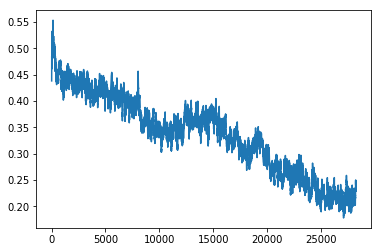

In [137]:
learn.sched.plot_loss()

In [43]:
#TODO slett denne senere 
sz = 256
data = get_data(sz)

In [44]:
learn = ConvLearner.pretrained(arch, data, opt_fn=optim.Adam, ps = 0.5) 

In [45]:
learn.load(f'{sz}dn121')

In [46]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy = accuracy_np(probs, y)

In [47]:
print(accuracy)
#HIT

0.9072088266286493


# Transfer learning 

In [79]:
sz = 64
data = get_data(sz)

In [80]:
learnTL = ConvLearner.pretrained(arch, data, opt_fn=optim.Adam, ps = 0.5) 

In [81]:
learnTL.load('64121Pneumothorax') #denne er for dn121 #pretrained weights on chestX 14 dataset 

In [ ]:
learnTL.lr_find()
learnTL.sched.plot()

 31%|███▏      | 1268/4034 [00:50<01:50, 25.09it/s, loss=0.656]

In [ ]:
lr = 0.00005

In [ ]:
learnTL.fit(lr,3, cycle_len=1, cycle_mult =2) 

In [ ]:
learnTL.lr_find()
learnTL.sched.plot()

In [ ]:
lrs = [1r/9,lr/3,lr]
learnTL.unfreeze()

In [ ]:
learnTL.fit(lrs, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learnTL.save(f'{sz}TL121')

In [ ]:
sz = 128

In [ ]:
learnTL.set_data(get_data(sz))
learnTL.freeze()

In [ ]:
learnTL.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learnTL.unfreeze()
learnTL.fit(lrs, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learnTL.save(f'{sz}TL121')

In [ ]:
sz = 256

In [ ]:
learnTL.set_data(get_data(sz))
learnTL.freeze()

In [ ]:
learnTL.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learnTL.save(f'{sz}TL121')

In [ ]:
learnTL.unfreeze()
learnTL.fit(lrs,3, cycle_len=1, cycle_mult=2)
#learnTL.save(f'{sz}TL') hvis den ikke overfitter

In [ ]:
learnTL.sched.plot_loss()

# Prediction on test set

In [48]:
df_test = pd.read_csv(f'{PATH}test_submission_example.csv', header=None)

In [49]:
df_test.shape

(209, 2)

In [50]:
df_test.columns = ['Study','Abnormality']

In [51]:
df_test['Study'] = df_test['Study'].str.replace("/", "_")
df_test['Study'] = df_test['Study'].str.replace("test_","test/")

In [52]:
# maa lable y 
data.test_ds.y[:5] #alle er 0 

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [53]:
pos = 0; 
df_pos_img_indxs = {}
for stud in df_test['Study']: #eksempel: stud:  test/XR_FOREARM_patient12044_study1_
    indices = [i for i, s in enumerate(data.test_ds.fnames) if stud in s] #posisjonen til alle som 
    for j in indices:
        data.test_ds.y[j] = df_test['Abnormality'][pos]
    
    df_pos_img_indxs[pos] = indices
    pos= pos+1; 

In [54]:
data.test_ds.y[:5]

array([[1.],
       [1.],
       [0.],
       [0.],
       [0.]])

In [55]:
len(df_pos_img_indxs)

209

In [56]:
df_pos_img_indxs[0]

[56, 186, 253]

In [57]:
data.test_ds.y[56], data.test_ds.y[186], data.test_ds.y[253]

(array([1.]), array([1.]), array([1.]))

In [58]:
log_preds,y = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds),0)
accuracy = accuracy_np(probs, y)

In [59]:
accuracy

0.4943212547322877

### Predict studies 

In [173]:
test_list = data.test_ds.fnames
len(test_list)

559

In [174]:
#fjerne imagex.png fra stringen, så man kan finne alle bildene for et studie
def searching_string(pasient_image_path):
    string_size = len(pasient_image_path) - len('image1.png')
    return pasient_image_path[:string_size] 

In [175]:
#finne indeksene til bildene som er med i studiet
def find_img_indxs(pasient_study): 
    return [test_list.index(i) for i in test_list if pasient_study in i]

In [176]:
trn_tfms, val_tfms = tfms_from_model(arch, sz) # get transformations
def predict_abnormality(fn): 
    im = open_image(fn)
    im_val = val_tfms(im)
    preds = learnTL.predict_array(im_val[None])
    return np.argmax(preds)

you should use the 2nd return val from tfms_from_model. The first one includes data augmentation, e.g. for the training set. For predictions you don’t want that, so use the 2nd one.
Jeremy

In [177]:
#fjerne indeksene til bildene fra test_list når man er ferdig med å predikere et studie. 
def del_indxs(study_img_indxs):
    #for i in study_img_indxs: 
       # del test_list[i] 
    return np.delete(test_list, study_img_indxs).tolist()

In [178]:
predictions_dict = {}

while(len(test_list)>0): 
    string_study = searching_string(test_list[0])
    study_img_indxs = find_img_indxs(string_study)
    
    prediction_list = [] #skal inneholde alle predikasjonene for et studie

    #Her skal det predikeres på hvert av bildene i studiet
    for i in study_img_indxs: 
        prediction = predict_abnormality(PATH+test_list[i])
        prediction_list.append(prediction)
        
    predictions_dict[string_study] = max(prediction_list) # nøkkel : navnet til studiet + value: predikasjonen (hvis en av de er True, så er studiet True)
    
    #ferdig med predikasjon for et studie
    test_list = del_indxs(study_img_indxs)
    #print(find_img_indxs(string_study)) #bare for å teste at alle listene som retuneres er tomme 

In [179]:
len(predictions_dict)

209

In [180]:
y = []
preds = []

In [181]:
def add_values(y_value, preds_value): 
    y.append(y_value)
    preds.append(preds_value)

In [182]:
def test_accuracy(pred_dict, df_test): 
    num_correct = 0; 
    for key, value in pred_dict.items(): 
        searching_string = key
        row = df_test.loc[df_test['Study'] == searching_string]
        print("Dictionary key: " + str(key) + " value: " + str(value))
        print(row.values[0][0],row.values[0][1])
        if(row.values[0][1] == value): 
            num_correct+=1
        
        add_values(row.values[0][1], value)
        print()
    return num_correct/len(pred_dict)

In [183]:
test_accuracy(predictions_dict, df_test)

Dictionary key: test/XR_SHOULDER_patient12168_study1_ value: 1
test/XR_SHOULDER_patient12168_study1_ 1

Dictionary key: test/XR_FINGER_patient12241_study1_ value: 1
test/XR_FINGER_patient12241_study1_ 1

Dictionary key: test/XR_ELBOW_patient12117_study1_ value: 1
test/XR_ELBOW_patient12117_study1_ 0

Dictionary key: test/XR_FOREARM_patient12056_study1_ value: 1
test/XR_FOREARM_patient12056_study1_ 0

Dictionary key: test/XR_SHOULDER_patient12183_study1_ value: 0
test/XR_SHOULDER_patient12183_study1_ 0

Dictionary key: test/XR_HAND_patient12092_study1_ value: 1
test/XR_HAND_patient12092_study1_ 1

Dictionary key: test/XR_FOREARM_patient12067_study1_ value: 0
test/XR_FOREARM_patient12067_study1_ 0

Dictionary key: test/XR_ELBOW_patient12124_study1_ value: 1
test/XR_ELBOW_patient12124_study1_ 1

Dictionary key: test/XR_HAND_patient12076_study1_ value: 0
test/XR_HAND_patient12076_study1_ 1

Dictionary key: test/XR_ELBOW_patient12128_study1_ value: 0
test/XR_ELBOW_patient12128_study1_ 0

Di

test/XR_FINGER_patient12248_study1_ 1

Dictionary key: test/XR_HUMERUS_patient12137_study1_ value: 1
test/XR_HUMERUS_patient12137_study1_ 1

Dictionary key: test/XR_HAND_patient12087_study1_ value: 1
test/XR_HAND_patient12087_study1_ 1

Dictionary key: test/XR_WRIST_patient12194_study1_ value: 1
test/XR_WRIST_patient12194_study1_ 0

Dictionary key: test/XR_SHOULDER_patient12186_study1_ value: 1
test/XR_SHOULDER_patient12186_study1_ 1

Dictionary key: test/XR_ELBOW_patient12115_study1_ value: 0
test/XR_ELBOW_patient12115_study1_ 0

Dictionary key: test/XR_FOREARM_patient12061_study1_ value: 0
test/XR_FOREARM_patient12061_study1_ 1

Dictionary key: test/XR_ELBOW_patient12120_study1_ value: 0
test/XR_ELBOW_patient12120_study1_ 1

Dictionary key: test/XR_HUMERUS_patient12147_study1_ value: 1
test/XR_HUMERUS_patient12147_study1_ 1

Dictionary key: test/XR_SHOULDER_patient12181_study1_ value: 0
test/XR_SHOULDER_patient12181_study1_ 0

Dictionary key: test/XR_FOREARM_patient12046_study1_ valu

0.5454545454545454

In [184]:
cm = confusion_matrix(y,preds);

[[51 38]
 [57 63]]


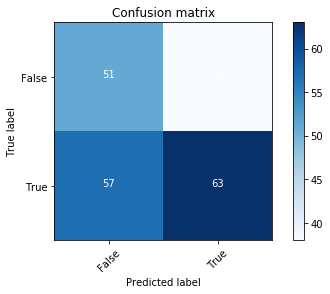

In [185]:
plot_confusion_matrix(cm, data.classes)